<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-from-BM32" data-toc-modified-id="Data-from-BM32-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data from BM32</a></span></li><li><span><a href="#Rotate-34ID-U's-around-the-110-axis" data-toc-modified-id="Rotate-34ID-U's-around-the-110-axis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Rotate 34ID U's around the 110 axis</a></span></li><li><span><a href="#Rotate-34ID-U's-around-the-011-axis" data-toc-modified-id="Rotate-34ID-U's-around-the-011-axis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rotate 34ID U's around the 011 axis</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Variation---transpose-the-U-matrix-for-calculating-the-axis" data-toc-modified-id="Variation---transpose-the-U-matrix-for-calculating-the-axis-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Variation - transpose the U matrix for calculating the axis</a></span></li><li><span><a href="#Variation---transpose-the-input-matrix" data-toc-modified-id="Variation---transpose-the-input-matrix-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Variation - transpose the input matrix</a></span></li></ul></li><li><span><a href="#Method-2." data-toc-modified-id="Method-2.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Method 2.</a></span></li><li><span><a href="#34ID-UBs---refined-spec-output" data-toc-modified-id="34ID-UBs---refined-spec-output-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>34ID UBs - refined spec output</a></span></li></ul></li><li><span><a href="#From-the-logbook" data-toc-modified-id="From-the-logbook-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>From the logbook</a></span></li></ul></div>

This notebook deals with the generation of orientation matrices to use on 34ID regarding experiment [63523](https://docs.google.com/document/d/1fC8Sf13tnWx4UPFKlOq2zkJREJDgG2O78-IcEFpUk0U/edit#) at APS.

In [3]:
LaueToolsCode_Folder = '/data/id01/inhouse/edo/lauetools_Rev2295_30March18/'
import sys
sys.path.append(LaueToolsCode_Folder)

In [4]:
import time, copy, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np    
import pickle
import transforms3d as tfs

import readwriteASCII as RWASCII   # read and write ASCII file  (IO) 
import readmccd as RMCCD       # read CCD and detector binary file, PeakSearch methods
import laue6
import dict_LaueTools as dc
import CrystalParameters as CP
import dict_LaueTools as DictLT

from generaltools import rotate_around_u, matRot, getRotationAngleFrom2Matrices
from find2thetachi import calc_uflab

from matplotlib.colors import LogNorm
from ipywidgets import interact
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.linalg import norm

%matplotlib inline
# %config InlineBackend.figure_format='retina'

LaueToolsProjectFolder /data/id01/inhouse/edo/lauetools_Rev2295_30March18
Missing library libtiff, Please install: pylibtiff if you need open some tiff images
Cython compiled module 'gaussian2D' for fast computation is not installed!
Cython compiled module for fast computation of Laue spots is not installed!


/usr/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def printround(x, dec=2):
    print(np.round(x, decimals=dec))

def Rz(angle):
    return tfs.euler.euler2mat(0,0,np.deg2rad(angle))

def Ry(angle):
    return tfs.euler.euler2mat(0,np.deg2rad(angle),0)

def Rx(angle):
    return tfs.euler.euler2mat(np.deg2rad(angle),0,0)

def angbetween(v1, v2):
    v1, v2 = np.array(v1), np.array(v2)
    ang = np.degrees(np.arccos(np.dot(v1, v2)/(norm(v1)*norm(v2))))

    return ang

def plot_simul(peak_x, peak_y, img_num):
    
    y, x = peak_y, peak_x

    plt.figure(figsize=(7,7), dpi=200)
    plt.imshow(candidates[img_num], vmin=0, vmax=120, cmap='gray_r')
    plt.scatter(x, y, s=50, facecolors='none', edgecolors='blue', linewidths=0.3)
    for i in range(posx.size):
        if np.all(abs(miller[i]) <= 4):
            index = miller[i]
            en = np.round(nrj[i], decimals=2)
        else:
            index = ''
            en = ''
        plt.text(x[i]+35, y[i], str(index), color='red', fontsize=9)
        plt.text(x[i]+35, y[i]+50, str(en), color='blue', fontsize=7)
    
def init_u32_111():
    # spits out the 111 U matrix of C5 corrected for the stage rotation in Bm32. This means 
    # this U matrix will rotate the 111 OOP.
    u32_111 = np.array([[-0.907114925923025,  0.189219271479824, -0.375950087633018],
                        [-0.42080574824087 , -0.390639680933938,  0.818732659867284],
                        [0.008058961711265,  0.900886608458518,  0.433979647969956]])
        
    return u32_111

def init_u34_111(u=True):
    # Spits out the 111 U matrix in 34ID. This matrix will rotate the 111 OOP.

    # initial UB from spec, 111 OOP
    ub_s1 = np.array([[-0.87182, -0.88931,-0.90590],
                       [-0.59836, 1.25710, -0.65823],
                       [1.11960, -0.02065, -1.05720]]).copy()

    # calculate the U matrix by dividing by a*
    u_s1 = np.dot(np.eye(3)*(4.08/(2*np.pi)), ub_s1)
    
    if u:
        return u_s1
    elif not u:
        return ub_s1

# Data from BM32
To understand what rotations one should attempt on 34ID.

In [6]:
# tif files img directory
imgdir = '/data/id01/inhouse/edo/20180515_HC3015_BM32/SiAu_C4/'

# load tif images
img_list = [im for im in os.listdir(imgdir) if 'tif' in im]
img_list.sort()
first_img = RMCCD.readCCDimage(img_list[0], dirname=imgdir, CCDLabel='sCMOS')
imin, imax = first_img[0].min(), first_img[0].max()

# load candidate img dict
candidate_img_numbers = [53, 249, 864, 1010, 1108, 1244, 2953, 2420, 2639, 2831, 3161, 3039, 2831]
sub_img_numbers =       (56, 200, 820, 1016, 1016, 1016, 2947, 2415, 2415, 2825, 2825, 2825, 2825)

candidates = {}

for img_num, sub_num in zip(candidate_img_numbers, sub_img_numbers):
    sub_img, img_size, det_type = RMCCD.readCCDimage(img_list[sub_num], dirname=imgdir, CCDLabel='sCMOS')
    sub_img = sub_img.astype('int16')
    img, img_size, det_type = RMCCD.readCCDimage(img_list[img_num], dirname=imgdir, CCDLabel='sCMOS')
    img = img.astype('int16')
    img -= sub_img
    img[img<0] = 0
    candidates[img_num] = img
    
# refined detector parameters for simulation
detector_params = [76.968, 1029.5, 1056.92, 0.454, 0.234] # distance, xcen, ycen, xbet, xgam
pixelsize = 0.0734
dim = (2018, 2016)
detectordiameter = 180#148.1212
emin = 5
emax = 25

In [7]:
u32_111 = init_u32_111()

# rotate reflection onto bm32 frame
v_110 = np.dot(u32_111, np.array([0,1,1]))

# create rotation matrix from such vector
R = tfs.axangles.axangle2mat(v_110, np.radians(-72))

# rotate bm32 u matrix around such vector
ubnew = u32_111
ubnew = np.dot(R, ubnew) # 72
# ubnew = np.dot(R, ubnew) # 144
# ubnew = np.dot(R, ubnew) # 216
# ubnew = np.dot(R, ubnew) # 288
# ubnew = np.dot(R, ubnew) # 360 back to the start

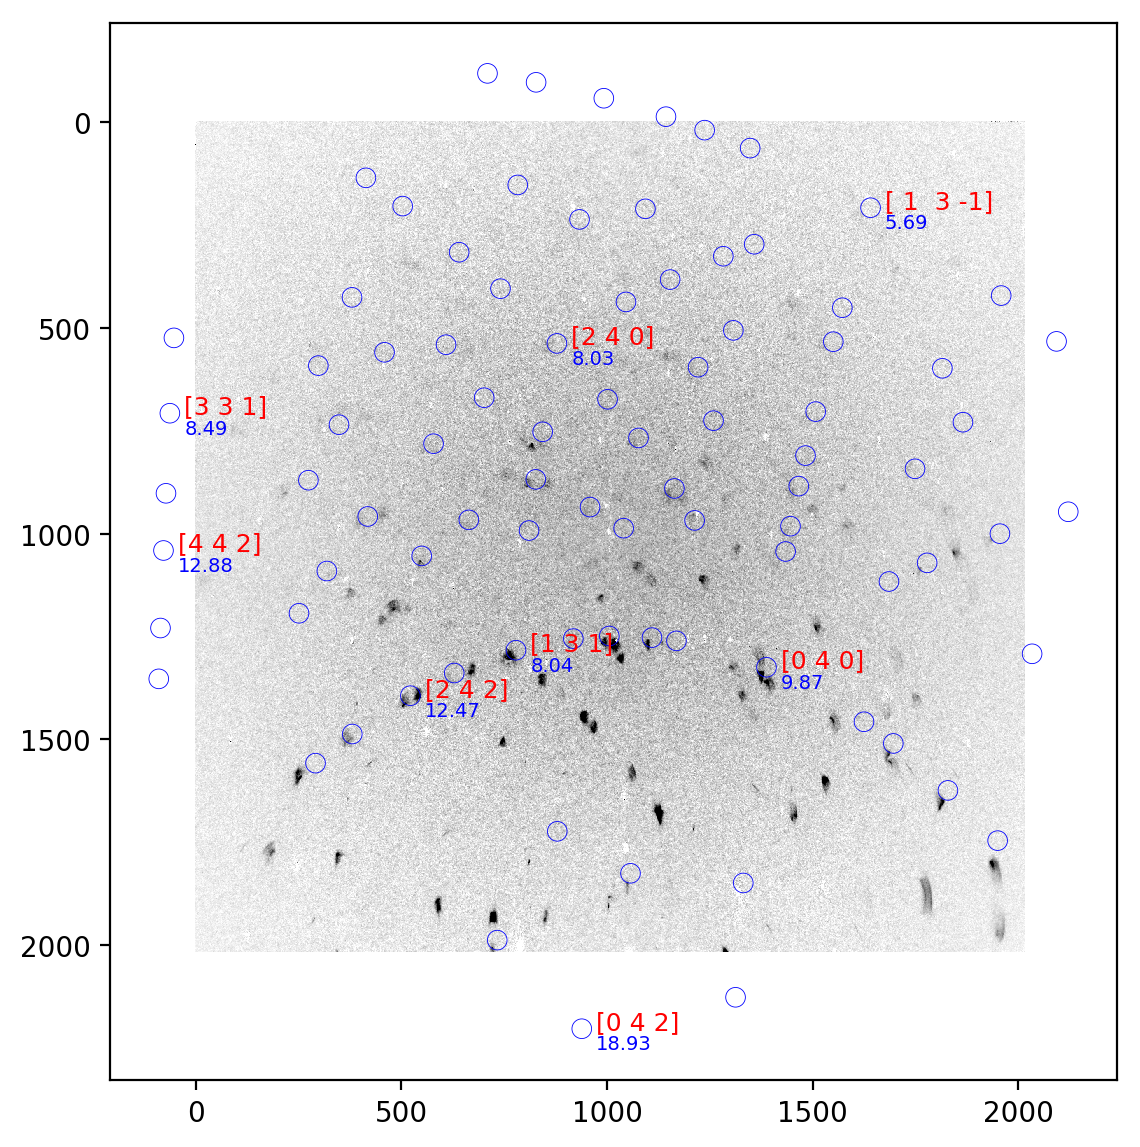

In [8]:
# make Au grain - returns [B, exctinctions, U, material_key]
grain = CP.Prepare_Grain('Au', OrientMatrix=ubnew) 

# simulate Laue pattern from grain
tth, chi, miller, posx, posy, nrj = laue6.SimulateLaue(grain, emin, emax, detector_params, 
                                                       pixelsize=pixelsize, dim=dim, 
                                                      detectordiameter=detectordiameter,
                                                      removeharmonics=1)
# plot the simulation
plot_simul(posx, posy, 249)

# Rotate 34ID U's around the 110 axis
Note that the right axis according to BM32 is actually the 011.

No transposes used at all below. This and the anticlockwise counterpart give us what we named in the logbook "segment 2" and "Segment 3", for which we found plenty of reflections, with several overlapping however (same angles in diffractometer space).

In [11]:
# UB matrix from 111 OOP @ 34ID
ub_s1 = init_u34_111(u=False)

# extract axis and make rotation
ax = np.dot(ub_s1, np.array([1,1,0]))
R = tfs.axangles.axangle2mat(ax, np.radians(72))
ub_new34 = np.dot(R, ub_s1)

# print result 
for line in ub_new34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

-0.268644977549 -1.49248502245 -0.268172098824
0.485344598472 0.173395401528 -1.45119640385
1.43662084726 -0.337670847257 0.440120558231


In [12]:
# UB matrix from 111 OOP @ 34ID
ub_s1 = init_u34_111(u=False)

# extract axis and make rotation
ax = np.dot(ub_s1, np.array([1,1,0]))
R = tfs.axangles.axangle2mat(ax, np.radians(-72))
ub_new34 = np.dot(R, ub_s1)

# print result 
for line in ub_new34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

-1.48708284319 -0.274047156806 -0.291702478292
-0.399972325281 1.05871232528 1.04438698875
0.0146873580425 1.08426264196 -1.09350759704


We can look at the angles corresponding to such saved positions (EDIT - file is empty, and I can't update it on Stevens folder)

In [18]:
from IPython.display import HTML
HTML(filename="/mntdirect/_data_id01_inhouse/edo/20190313_63523_34IDC/Experiment/old_angle_list.html")

# Rotate 34ID U's around the 011 axis
Which corresponds wo what works on the BM32 Laue.

This we labelled as "c5_-72", then we generated others by rotating again by the same amount.

In [24]:
# UB matrix from 111 OOP @ 34ID
ub_s1 = init_u34_111(u=False)

# extract axis and make rotation
ax_011 = np.dot(ub_s1, np.array([0,1,1]))
R = tfs.axangles.axangle2mat(ax_011, np.radians(72))
ub_new34 = np.dot(R, ub_s1)
ub_new34 = np.dot(R, ub_new34)
ub_new34 = np.dot(R, ub_new34)
ub_new34 = np.dot(R, ub_new34)

# print result 
for line in ub_new34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

-0.280565487437 -1.48133919476 -0.313870805236
-1.47296215037 0.192974337517 0.405895662483
-0.351104646556 0.374157992987 -1.45200799299


 But the subsequent rotations are not matching with the logbook, wtf? probably because we were using the 34ID "refined" U matrixes for the subsequent rotations (see end of this notebook). Make the rotations in the cell above and compare with the refined matrices:

In [ ]:
ub_m72_011 = np.array([[-0.26734, -1.49208, -0.27174],
          [1.04278, -0.38119, 1.06719],
          [-1.10124, 0.00126, 1.07650]])

ub_m144_011 = np.array([[-0.89522, -0.87498, -0.89700],
                       [-0.68496, -0.58142, 1.25075],
                       [-1.04929, 1.12604, -0.05119]])

ub_m216_011 = np.array([[-0.29711, -0.27637, -1.48558],
                        [-1.44308, 0.50092, 0.19543],
                        [0.44815, 1.42979, -0.35562]])

ub_m288_011 = np.array([[0.75327, -0.48946, -1.25085],
                         [0.22900, 1.36632, -0.67255],
                          [1.32354, 0.51497, 0.59553]])

Very different.

### Variation - transpose the U matrix for calculating the axis
As suggested by [this](https://pymicro.readthedocs.io/projects/pymicro/en/latest/cookbook/euler_angles.html)

In [117]:
# UB matrix from 111 OOP @ 34ID
ub_s1 = init_u34_111(u=False)

# extract axis and make rotation
ax_011 = np.dot(ub_s1.T, np.array([0,1,1]))
R = tfs.axangles.axangle2mat(ax_011, np.radians(-72))
ub_new34 = np.dot(R, ub_s1)

# print result 
for line in ub_new34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

0.107157014199 -1.51610074114 -0.248100203776
-1.5361256235 -0.109153076239 0.00355154047513
-0.0210809187227 0.247231181808 -1.51987731687


### Variation - transpose the input matrix
This is not really correct.

In [25]:
# UB matrix from 111 OOP @ 34ID
ub_s1 = init_u34_111(u=False).copy().T

# extract axis and make rotation
ax_011 = np.dot(ub_s1, np.array([1,1,0]))
R = tfs.axangles.axangle2mat(ax_011, np.radians(-72))
ub_new34 = np.dot(R, ub_s1)

# print result 
for line in ub_new34.T:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

-0.0244150496127 -0.161632002751 -1.53129886029
-1.44576495039 0.529422002751 -0.0328311397056
0.529878351361 1.43707681897 -0.160129858679


## Method 2.
Extract axis from transformed BM32 U matrix - NOT WORKING (SEE 34 TO 32 NOTEBOOK)

In [14]:
# UB matrix from 111 OOP @ 34ID
ub_s1 = init_u34_111(u=False)

# extract axis and make rotation
ax_011 = np.dot(ub_s1, np.array([0,1,1]))
R = tfs.axangles.axangle2mat(ax_011, np.radians(-72))
ub_new34 = np.dot(R, ub_s1)

# print result 
for line in ub_new34:
    print('{0} {1} {2}'.format(line[0], line[1], line[2]))

-0.280565487437 -1.48133919476 -0.313870805236
-1.47296215037 0.192974337517 0.405895662483
-0.351104646556 0.374157992987 -1.45200799299


## 34ID UBs - refined spec output
Except the last two, which however worked fine

In [ ]:
ub_s1 = np.array([[-0.87182, -0.88931,-0.90590],
                   [-0.59836, 1.25710, -0.65823],
                   [1.11960, -0.02065, -1.05720]]).T.copy()#.T.copy()

ub_m72_011 = np.array([[-0.26734, -1.49208, -0.27174],
          [1.04278, -0.38119, 1.06719],
          [-1.10124, 0.00126, 1.07650]]).T.copy()

ub_m144_011 = np.array([[-0.89522, -0.87498, -0.89700],
                       [-0.68496, -0.58142, 1.25075],
                       [-1.04929, 1.12604, -0.05119]])#.T.copy()

ub_m216_011 = np.array([[-0.29711, -0.27637, -1.48558],
                        [-1.44308, 0.50092, 0.19543],
                        [0.44815, 1.42979, -0.35562]]).T.copy()


ub_m288_011 = np.array([[0.75327, -0.48946, -1.25085],
                         [0.22900, 1.36632, -0.67255],
                          [1.32354, 0.51497, 0.59553]]).T.copy()
##

ub_s2 = np.array([[-1.487082843194333, -0.274047156805667, -0.291702478291803],
                  [-0.399972325281125,  1.058712325281125,  1.044386988753434],
                  [ 0.014687358042543,  1.084262641957457, -1.093507597038519]]).T.copy()

ub_s3 = np.array([[-0.268644977548564, -1.492485022451436, -0.268172098823906],
                  [0.485344598471726,  0.173395401528274, -1.451196403845826],
                  [1.436620847256593, -0.337670847256593,  0.440120558230723]]).T.copy()

# From the logbook

-72 deg rotation:

From BM32 → 34ID with the 120deg rotation (unrealistic - but it works at least for two subunits)
```
-0.286230456354 -1.48872076645 -0.270871623702
-1.47065224719 0.208810552944 0.406409751834
-0.356149963908 0.334211729297 -1.46049598358
```

From rotating in 34ID directly:
```
-0.280565487437 -1.48133919476 -0.313870805236
-1.47296215037 0.192974337517 0.405895662483
-0.351104646556 0.374157992987 -1.45200799299
```

Note these are almost the same - confirms the rotation is correct.
However it does not work. Try again with the transpose-->rotate-->transpose method. From 34ID directly.
-72:

```
0.885913797306 -1.1340992032 -0.548245327874
-0.591115256339 0.217587162706 -1.40529015255
1.11235525634 1.01886283729 -0.310139847452
```

Again same rotation, but ubnew34 = np.dot(ub_s1, ubrot)
I.e. rotation matrix applied postmultipled in the dot product

```
-0.349646215244 0.741258135613 -1.30379529042
-0.347722595215 1.26221343101 0.810864432895
1.45891928596 0.478490062132 -0.119206103208
```

Which seems to work… wtf? EDIT - it does not.

Bm32 → 34ID without weird rotations (HELLO! IT'S WRONG)

```
0.286230456354 1.48872076645 0.270871623702
1.05222551749 -0.393935751604 1.05319739752
1.08742001513 -0.0106747659592 -1.09040939389
```